In [1]:
%load_ext autoreload
%autoreload 2

# System imports
from dataclasses import dataclass
from typing import NamedTuple, Callable, Optional
import time

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi
import optax

# Local imports
import loss
import dataset
from model import VGAE, VGAEOutput
import plotting

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
RNG_KEY = jax.random.PRNGKey(3)

In [3]:
IMAGE_SHAPE = (15, 10)

(
    A, D, d, 
    num_regions, 
    (num_x, num_y),
) = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

np.linalg.det(np.linalg.inv(D - A))

0.0

In [4]:
from typing import Dict

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  
  decoder_params: Optional[Params] = None
  priorvae_decoder_params: Optional[Params] = None
  scaler: Optional[callable] = None
  
CAR_ARGS = CARArgs()

In [5]:
def car_predictive_model(args: CARArgs) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)

  alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))

  Q = (D - alpha*A)
  numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(num_regions), precision_matrix=Q))

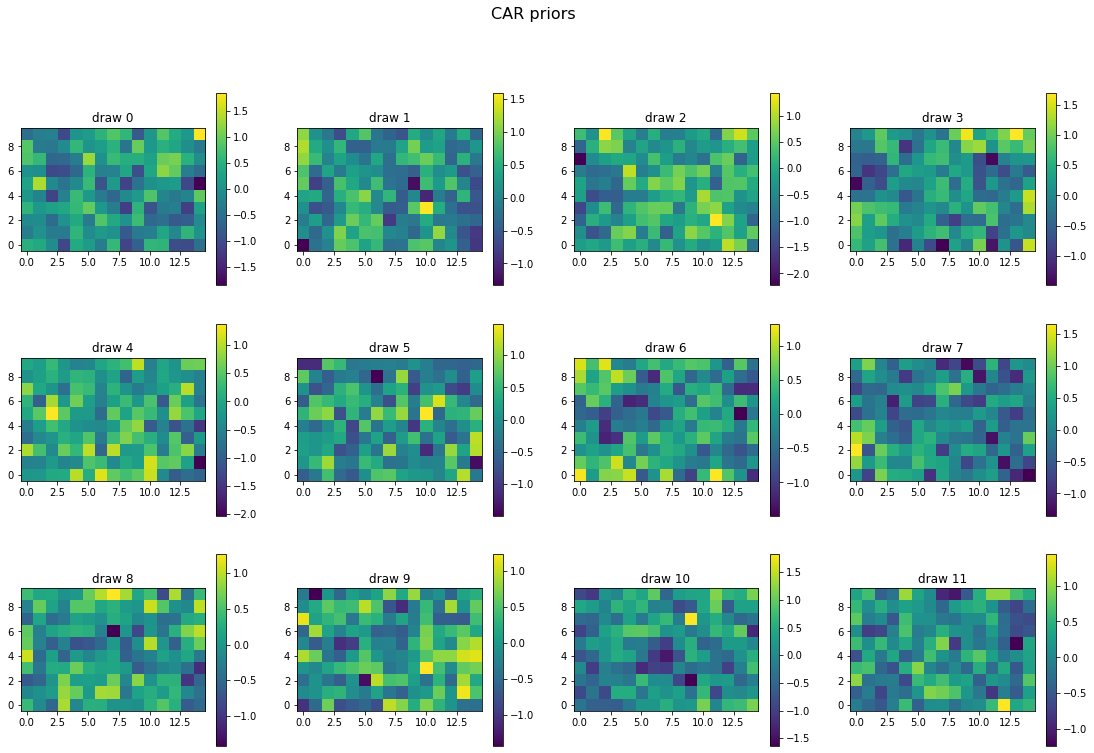

In [6]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_preds = Predictive(car_predictive_model, num_samples=20)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

plotting.plot_samples(car_draws, image_shape=IMAGE_SHAPE)

In [7]:
def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car']  # (batch_size, num_regions)
    return car_draws

def generate_graph_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_draws = generate_car_batch(rng, batch_size, model_args)
    graphs = [
        dataset.get_car_draws_as_graph(draw.reshape(-1, 1), A) 
            for draw in car_draws
    ]
    return jraph.batch(graphs)

I should expect larger `scale` to have better performance on the decoder as now the KL-divergence is imposed correctly?

In [8]:
LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class Args:
  loss_fn: LossFun = loss.compute_mse_loss
  num_nodes: int = A.shape[0]
  batch_size: int = 1
  
  # Scaler options:
  #   - None: NoScaler (.preprocess.NoScaler)
  #   - linear: LinearScaler (.preprocess.LinearScaler)
  #   - standard: StandardScaler (sklearn.preprocessing.StandardScaler)
  #   - robust: RobustScaler (sklearn.preprocessing.RobustScaler)
  scaler: str = None
  linear_scale: int = 10.0  # For LinearScaler: discovered that bigger is not always better.
  
  act_fn = jax.nn.elu
  hidden_dim: int = 30  # [10, 20, 50, 100, 200, 500, 1000]
  latent_dim: int = 20
  output_dim: int = 1
  
  learning_rate: float = 1e-4 # 8e-3
  epochs: int = 100_000
  beta: float = 0.01  # for beta-VAE
  global_norm_clip: float = 1.0  # if scheduling learning rate, this is the max norm of the gradients
  
  eval_frequency: int = 1_000

ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=10.0, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


In [9]:
available_scalers = [
  None,
  'linear',
  'standard',
  'robust',
]
if ARGS.scaler not in available_scalers:
  raise ValueError(f"Scaler {ARGS.scaler} not available. Available scalers: {available_scalers}")
if ARGS.scaler != 'linear':
  ARGS.linear_scale = None
  
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


In [10]:
from pathlib import Path
train_path = Path.cwd() / 'dataset/synthetic_car_train_data_ALPHA_0.4_0.99.npy'
val_path = Path.cwd() / 'dataset/synthetic_car_val_data_ALPHA_0.4_0.99.npy'

OVERRIDE_SAVE = False

RNG_KEY, train_rng, val_rng = jax.random.split(RNG_KEY, 3)
if (train_path.exists() and val_path.exists()) and not OVERRIDE_SAVE:
    train_data = jnp.array(np.load(train_path))
    val_data = jnp.array(np.load(val_path))
else:
    train_data = generate_car_batch(train_rng, batch_size=1_000_000)
    val_data = generate_car_batch(val_rng, batch_size=1_000_000)
    np.save(train_path, np.asarray(train_data))
    np.save(val_path, np.asarray(val_data))

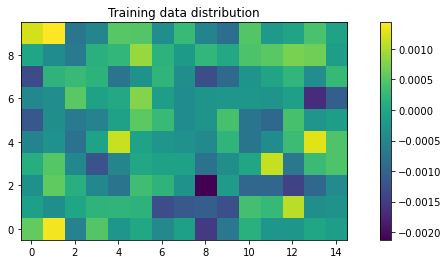

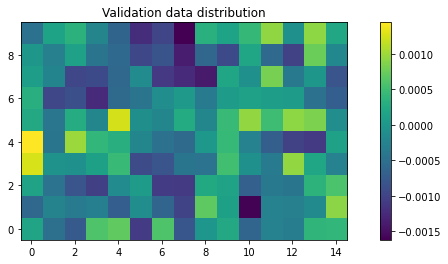

In [11]:
# Plot train and validation data distribution
plotting.plot_images_from_arrays(
    arrays=[train_data.mean(axis=0)],
    titles=['Training data distribution'],
    image_shape=IMAGE_SHAPE,
);

plotting.plot_images_from_arrays(
    arrays=[val_data.mean(axis=0)],
    titles=['Validation data distribution'],
    image_shape=IMAGE_SHAPE,
);

In [12]:
# half_epochs = ARGS.epochs // 2

# train_data = np.vstack((
#     train_data[:ARGS.epochs], 
#     -train_data[:ARGS.epochs],
# ))
# val_data = np.vstack((
#     val_data[:ARGS.epochs], 
#     -val_data[:ARGS.epochs],
# ))

In [13]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from dataset import LinearScaler, NoScaler

if ARGS.scaler == 'linear':
    scaler = LinearScaler(scale=ARGS.linear_scale)
elif ARGS.scaler == 'standard':
    scaler = StandardScaler()
elif ARGS.scaler == 'robust':
    scaler = RobustScaler()
else:
    scaler = NoScaler()

scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

base_graph = dataset.create_grid_graph(A)
scaled_graph_train_data = [
    base_graph._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_train_data
]
scaled_graph_val_data = [
    base_graph._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_val_data
]

# CAR_ARGS.scaler = scaler

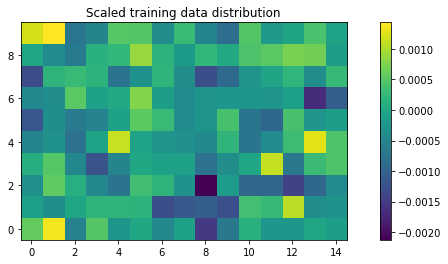

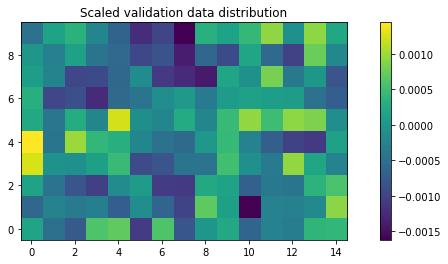

In [14]:
# Plot train and validation data distribution
plotting.plot_images_from_arrays(
    arrays=[scaled_train_data.mean(axis=0)],
    titles=['Scaled training data distribution'],
    image_shape=IMAGE_SHAPE,
);

plotting.plot_images_from_arrays(
    arrays=[scaled_val_data.mean(axis=0)],
    titles=['Scaled validation data distribution'],
    image_shape=IMAGE_SHAPE,
);

In [15]:
from functools import partial
from typing import Tuple

import layer
    
def encoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        latent_dim: int,
        act_fn: Callable = jax.nn.elu
    ) -> Tuple[jraph.GraphsTuple, jraph.GraphsTuple]:

    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # No activation
    gn_mean = jraph.GraphConvolution(
        update_node_fn=hk.Linear(latent_dim),
        add_self_edges=False,
    )
    gn_log_std = jraph.GraphConvolution(
        update_node_fn=hk.Linear(latent_dim),
        add_self_edges=False,
    )
    mean_graph, log_std_graph = gn_mean(graph), gn_log_std(graph)
    
    return mean_graph, log_std_graph


def decoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        output_dim: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_dim, name='decoder_hidden'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # No activation
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Linear(output_dim, name='decoder_output'),
        add_self_edges=False,
    )
    graph = gn(graph)

    return graph


class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_dim,
        latent_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self._hidden_dim = hidden_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean_graph, log_std_graph = encoder(
            graph,
            self._hidden_dim,
            self._latent_dim,
        )
        mean, log_std = mean_graph.nodes, log_std_graph.nodes
        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)
        z_graph = mean_graph._replace(nodes=z)
        output = decoder(
            z_graph,
            self._hidden_dim,
            self._output_dim,
        )

        return VGAEOutput(mean, log_std, output)

In [16]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=ARGS.hidden_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim)(x))

optimizer = optax.adam(ARGS.learning_rate)

# scheduler = optax.exponential_decay(
#     init_value=ARGS.learning_rate,
#     transition_steps=2000,
#     decay_rate=0.99,
# )

# # Combining gradient transforms using `optax.chain`
# optimizer = optax.chain(
#     optax.clip_by_global_norm(ARGS.global_norm_clip),  # Clip by the gradient by the global norm.
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
#     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0)
# )

In [17]:
from model import VGAEOutput

@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  # Apply beta-VAE
  elbo = (1.0/ARGS.beta)*log_likelihood - kld
  # # Apply sigma-VAE
  # elbo = ARGS.num_nodes*jnp.log(SIGMA) + ARGS.num_nodes/(2.0*jnp.square(SIGMA))*log_likelihood - kld
  
  return -elbo, kld
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [18]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = scaled_graph_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [19]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []
train_klds = []
val_klds = []

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  train_graph_batch = scaled_graph_train_data[epoch % ARGS.epochs]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = scaled_graph_val_data[epoch % ARGS.epochs]
    val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
          f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
          # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
    )
      
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_klds.append(train_kld)
    val_klds.append(val_kld)

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x16a264ca0>
18:12:06 STEP: 0; Train loss: 74.160; Validation loss: 37.589; 
18:12:06 STEP: 1000; Train loss: 21.990; Validation loss: 22.728; 
18:12:07 STEP: 2000; Train loss: 26.717; Validation loss: 31.466; 
18:12:07 STEP: 3000; Train loss: 26.082; Validation loss: 24.203; 
18:12:08 STEP: 4000; Train loss: 27.700; Validation loss: 24.342; 
18:12:08 STEP: 5000; Train loss: 30.263; Validation loss: 21.887; 
18:12:09 STEP: 6000; Train loss: 26.267; Validation loss: 22.572; 
18:12:09 STEP: 7000; Train loss: 26.770; Validation loss: 21.651; 
18:12:10 STEP: 8000; Train loss: 22.892; Validation loss: 28.102; 
18:12:10 STEP: 9000; Train loss: 32.579; Validation loss: 24.335; 
18:12:11 STEP: 10000; Train loss: 24.882; Validation loss: 19.674; 
18:12:11 STEP: 11000; Train loss: 18.494; Validation loss: 24.800; 
18:12:12 STEP: 12000; Train loss: 30.578; Validation loss: 20.570; 
18:12:12 STEP: 13000; Train loss: 24.357; Validation loss: 22.729; 
18:12:13 S

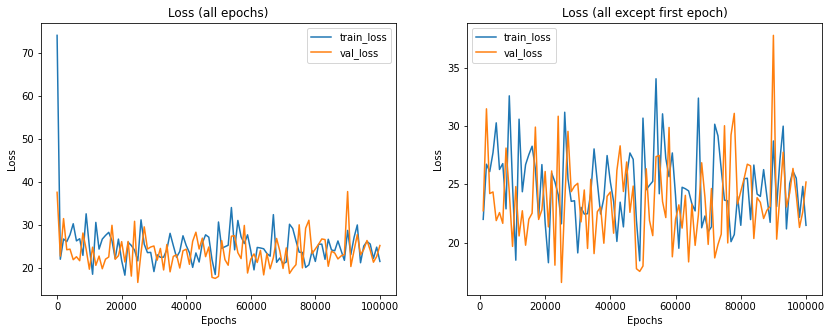

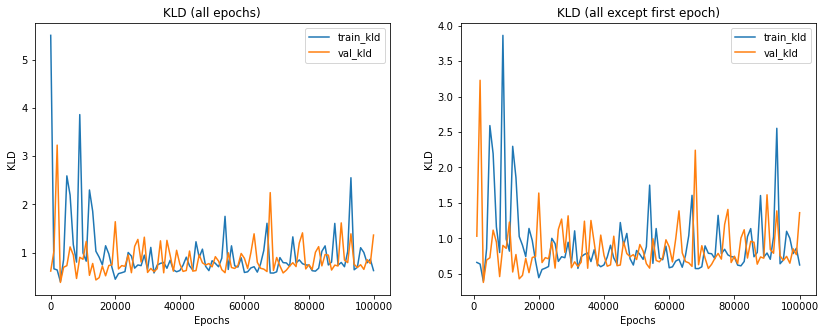

In [20]:
from matplotlib.ticker import MaxNLocator

# Loss plots
_, axes = plt.subplots(1, 2, figsize=(14, 5))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0].plot(xs, train_losses, label='train_loss')
axes[0].plot(xs, val_losses, label='val_loss')
axes[1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0].set_title('Loss (all epochs)')
axes[1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[i].set_ylabel('Loss')
    axes[i].set_xlabel('Epochs')
    axes[i].legend()

# KLD plots
_, axes = plt.subplots(1, 2, figsize=(14, 5))

xs = np.arange(len(train_klds))*ARGS.eval_frequency
axes[0].plot(xs, train_klds, label='train_kld')
axes[0].plot(xs, val_klds, label='val_kld')
axes[1].plot(xs[1:], train_klds[1:], label='train_kld')
axes[1].plot(xs[1:], val_klds[1:], label='val_kld')
axes[0].set_title('KLD (all epochs)')
axes[1].set_title('KLD (all except first epoch)')

for i in range(2): 
    axes[i].set_ylabel('KLD')
    axes[i].set_xlabel('Epochs')
    axes[i].legend()
plt.show()

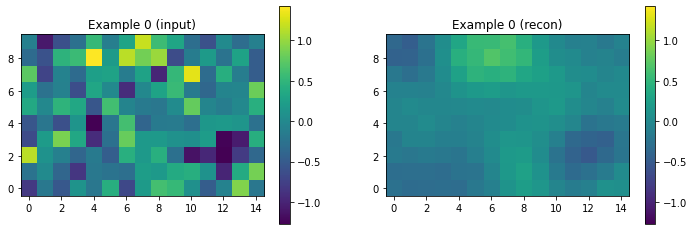

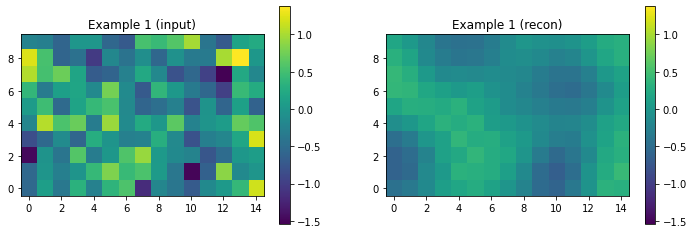

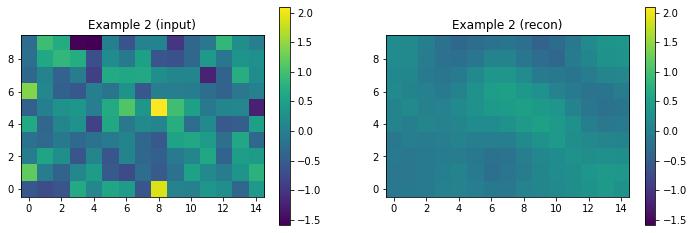

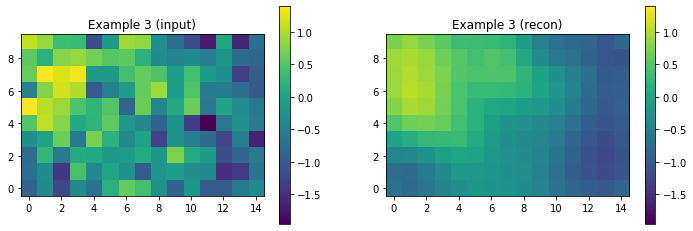

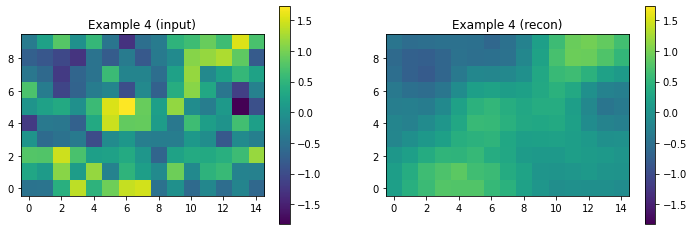

In [21]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

for i in range(5):
    original_data = val_data[i]
    scaled_data_graph = scaled_graph_val_data[i]
    outputs = net.apply(params, RNG_KEY, scaled_data_graph)
    
    # Unscaling
    recon_data = scaler.inverse_transform(outputs.output.nodes.T)

    original_image = jnp.ravel(original_data)
    recon_image = jnp.ravel(recon_data)

    _, ax, _ = plotting.plot_images_from_arrays(
        arrays=[original_image, recon_image],
        titles=['input', 'recon'],
        image_shape=IMAGE_SHAPE,
    )
    
    ax[0].set_title(f'Example {i} (input)')
    ax[1].set_title(f'Example {i} (recon)')

In [22]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


In [23]:
decoder_params = {
  'decoder_hidden': params['vgae/decoder_hidden'],
  'decoder_output': params['vgae/decoder_output'],
}
CAR_ARGS.decoder_params = decoder_params

decoder_net = hk.without_apply_rng(hk.transform(
  lambda g: decoder(g, 
                    hidden_dim=ARGS.hidden_dim, 
                    output_dim=ARGS.output_dim))
)

In [24]:
def vgae_predictive_model(args: CARArgs, 
                       y: Optional[jnp.ndarray] = None, 
                       noise: Optional[jnp.ndarray] = None) -> None:
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.num_nodes, ARGS.latent_dim]))
    z_graph = base_graph._replace(nodes=z)
    
    # The transpose is because we initially used 
    # more than one samples ~ N(0, 1) as features for each node
    out = jnp.squeeze(decoder_net.apply(args.decoder_params, z_graph).nodes.T)
    
    # Robust scaler
    # out = out*scaler.scale_ + scaler.center_
    
    # Linear scaler
    # out = 1.0/ARGS.linear_scale * out
    
    car_vgae = numpyro.deterministic('car_vgae', out)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car_vgae, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car_vgae, noise), obs=y)

In [25]:
vgae_preds = Predictive(vgae_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
vgae_draws = vgae_preds['car_vgae']

car_preds = Predictive(car_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

assert vgae_draws.shape == car_draws.shape, 'vgae_draws dimensions do not match car_draws dimensions'

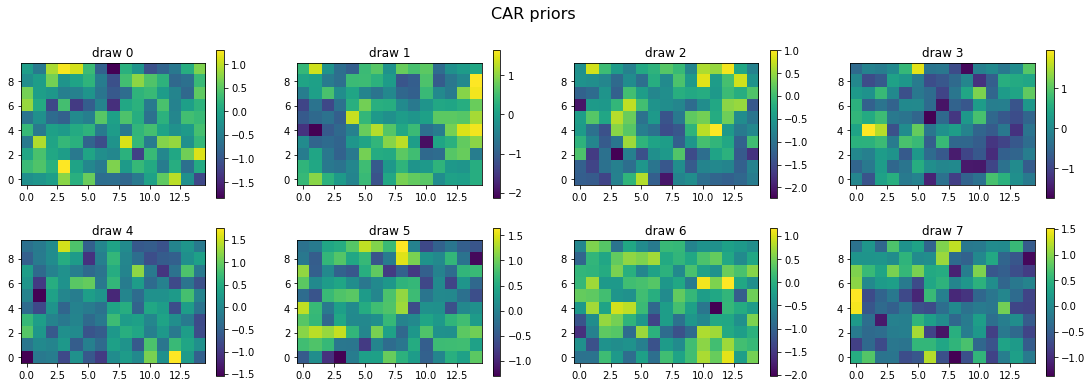

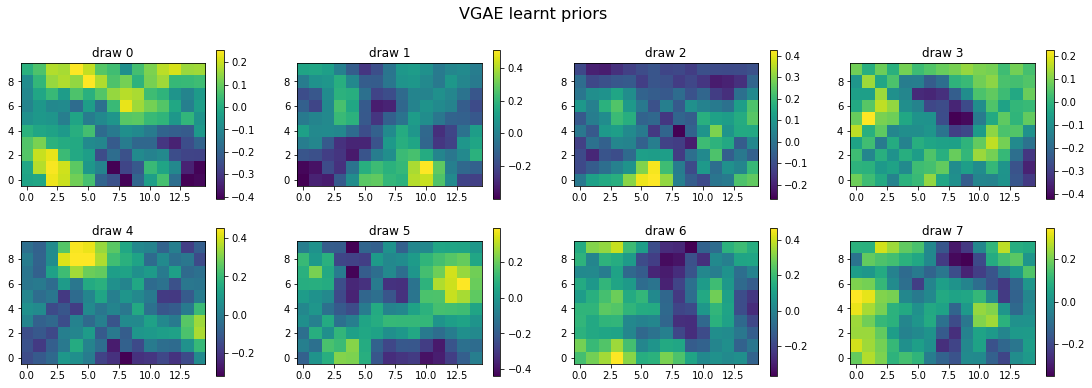

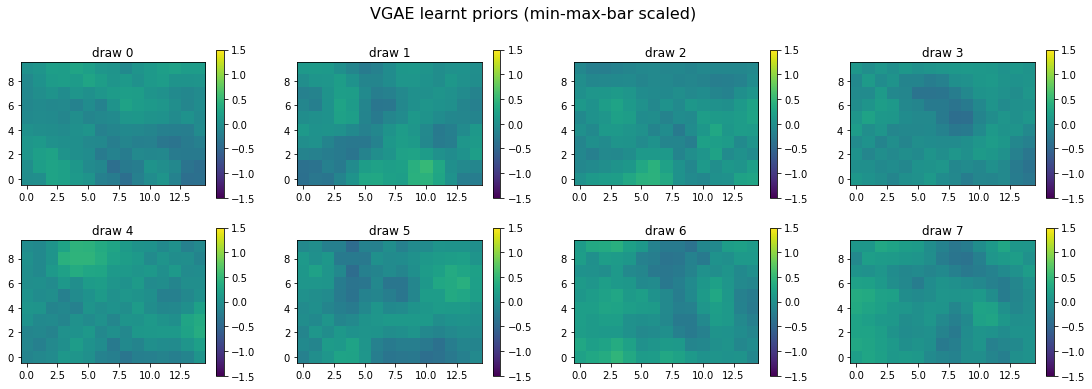

Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


In [26]:
plotting.plot_samples(car_draws, rows=2, figsize=(19, 6), image_shape=IMAGE_SHAPE)
plotting.plot_samples(vgae_draws, rows=2, figsize=(19, 6), title=f'VGAE learnt priors', image_shape=IMAGE_SHAPE)
plotting.plot_samples(vgae_draws, rows=2, figsize=(19, 6), title='VGAE learnt priors (min-max-bar scaled)', custom_min=-1.5, custom_max=1.5)
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


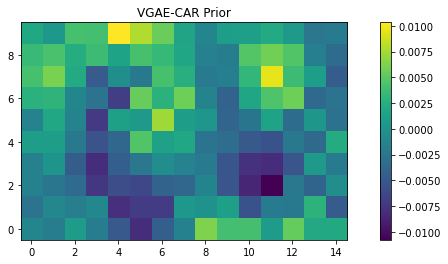

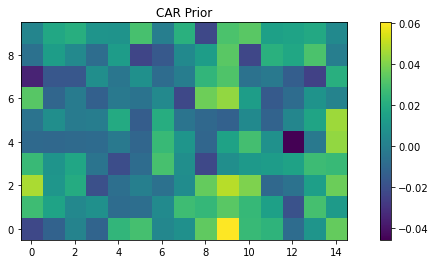

In [27]:
# VAE-CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

num_samples = 1000
car_draws = Predictive(car_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car']
vgae_draws = Predictive(vgae_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car_vgae']

mean_prior_pred_vgae = np.mean(vgae_draws, axis=0)
hpdi_prior_pred_vgae = hpdi(vgae_draws, 0.89)
mean_prior_pred_car = np.mean(car_draws, axis=0)
hpdi_prior_pred_car = hpdi(car_draws, 0.89)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_vgae],
    titles=['VGAE-CAR Prior'],
    image_shape=IMAGE_SHAPE,
)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_car],
    titles=['CAR Prior'],
    image_shape=IMAGE_SHAPE,
);

## Inference on observed data

### Ground truth to be inferred

In [28]:
def car_predictive_model_with_noise(
    args: CARArgs, y=None, alpha=None, noise=None) -> None:
    A = args.adj_matrix
    D = jnp.diag(args.degree_vector)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha*A)
    
    car = numpyro.sample(
        'car', dist.MultivariateNormal(
            loc=jnp.zeros(num_regions), precision_matrix=Q))
    numpyro.deterministic('car_samples', car)
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car, noise), obs=y)

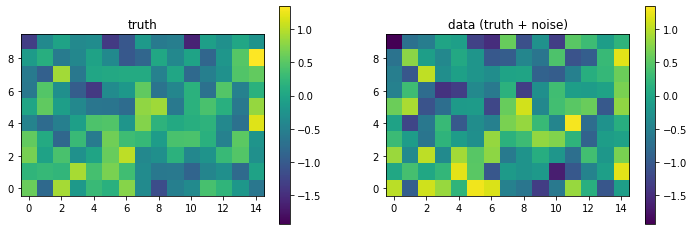

In [29]:
# Generate ground truth - fix alpha
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_predictive = Predictive(car_predictive_model_with_noise, num_samples=1)
car_preds = car_predictive(rng_pred, CAR_ARGS, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data],
    titles=['truth', 'data (truth + noise)'],
    image_shape=IMAGE_SHAPE
);

### Inference using VGAE-CAR model

In [30]:
def vgae_predictive_model(args: CARArgs, 
                       y: Optional[jnp.ndarray] = None, 
                       noise: Optional[jnp.ndarray] = None) -> None:
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.num_nodes, ARGS.latent_dim]))
    z_graph = base_graph._replace(nodes=z)
    
    # The transpose is because we initially used 
    # more than one samples ~ N(0, 1) as features for each node
    out = jnp.squeeze(decoder_net.apply(args.decoder_params, z_graph).nodes.T)
    
    # Robust scaler
    # out = out*scaler.scale_ + scaler.center_
    
    # Linear scaler
    # out = 1.0/ARGS.linear_scale * out
    
    car_vgae = numpyro.deterministic('car_vgae', out)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car_vgae, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car_vgae, noise), obs=y)

In [31]:
print(ARGS.latent_dim * ARGS.num_nodes)

3000


In [32]:
RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)

# Inference time
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(vgae_predictive_model, init_strategy=init_strategy)
mcmc = MCMC(
    kernel,
    num_warmup=1000, 
    num_samples=2000,
)
mcmc.run(rng_mcmc, CAR_ARGS, y=y_data)
mcmc_vgae_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [00:19<00:00, 150.17it/s, 31 steps of size 1.91e-01. acc. prob=0.87]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  car_vgae[0]      0.07      0.15      0.08     -0.18      0.32   4145.38      1.00
  car_vgae[1]      0.08      0.17      0.08     -0.23      0.34   3800.66      1.00
  car_vgae[2]      0.13      0.15      0.13     -0.11      0.37   4239.72      1.00
  car_vgae[3]      0.16      0.14      0.16     -0.06      0.42   4163.82      1.00
  car_vgae[4]      0.19      0.15      0.19     -0.04      0.43   4239.91      1.00
  car_vgae[5]      0.15      0.14      0.15     -0.09      0.37   3907.45      1.00
  car_vgae[6]      0.07      0.15      0.06     -0.16      0.31   3875.46      1.00
  car_vgae[7]     -0.05      0.14     -0.05     -0.28      0.19   3697.53      1.00
  car_vgae[8]     -0.13      0.14     -0.13     -0.36      0.11   3541.39      1.00
  car_vgae[9]     -0.18      0.14     -0.18     -0.41      0.05   4387.42      1.00
 car_vgae[10]     -0.17      0.14     -0.17     -0.40      0.07   4563.40  

In [33]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car_vgae']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 23 s
Average ESS for all CAR effects : 4206


Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


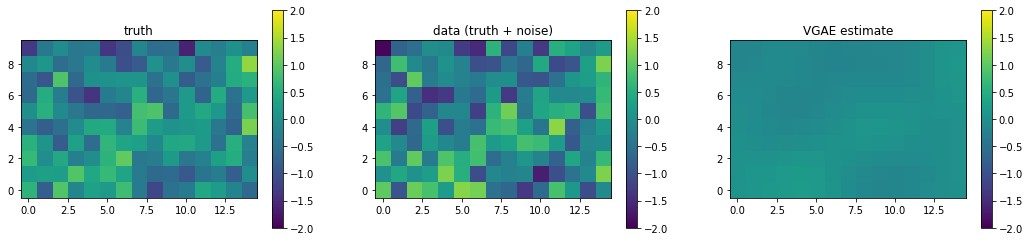

In [34]:
# Posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

posterior_predictions = Predictive(vgae_predictive_model, mcmc_vgae_samples)(rng_pred, CAR_ARGS)
post_obs = posterior_predictions['car_vgae']

mean_post_pred_vgae = np.mean(post_obs, axis=0)
bci_vgae_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_vgae_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_vgae = hpdi(post_obs, 0.9)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_vgae],
    titles=['truth', 'data (truth + noise)', 'VGAE estimate'],
    figsize=(18, 4),
    image_shape=IMAGE_SHAPE,
    custom_min=-2.0,
    custom_max=2.0
);

mse_vgae = 0.2648072838783264


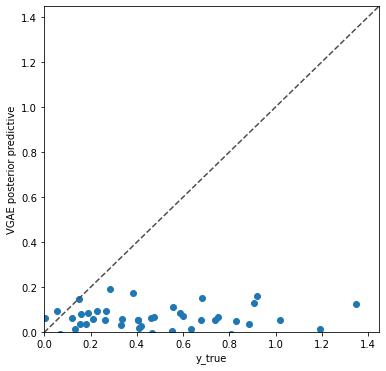

In [35]:
plotting.plot_compare_estimates(
    data_x=y_truth, data_y=mean_post_pred_vgae,
    x_label='y_true', y_label='VGAE posterior predictive',
    figsize=(6, 6),
)

mse_vgae = np.mean((y_truth -  mean_post_pred_vgae)**2)
print(f'mse_vgae = {mse_vgae}')

In [36]:
# assert False

### Inference on observed data with PriorVAE

In [37]:
from model import restore_params

model_name = 'priorVAE_CAR_h130l130_lr0.001_epochs5000_batchSize100'
model_path = Path('./models/priorVAE/') / model_name

if model_path.exists():
    print(f"Loading model from {model_path}")
    vae_params = restore_params(model_path)
    vae_decoder_params = {
        'decoder_hidden': vae_params['prior_vae/decoder_hidden'],
        'output': vae_params['prior_vae/output'],
    }
    CAR_ARGS.priorvae_decoder_params = vae_decoder_params
else:
    raise FileNotFoundError(f"Model {model_path} not found")

Loading model from models/priorVAE/priorVAE_CAR_h130l130_lr0.001_epochs5000_batchSize100


In [38]:
model_name.split('_')

['priorVAE', 'CAR', 'h130l130', 'lr0.001', 'epochs5000', 'batchSize100']

In [39]:
def priorvae_decoder(
        z: jnp.ndarray,
        hidden_dim: int,
        output_dim: int) -> jraph.GraphsTuple:
    output = hk.Sequential(
        [
            hk.Linear(hidden_dim, name='decoder_hidden'),
            jax.nn.elu,
            hk.Linear(output_dim, name='output'),
        ]
    )(z)
    output = jnp.reshape(output, (-1, output_dim))
    return output

vae_decoder_net = hk.without_apply_rng(
  hk.transform(
    lambda z: priorvae_decoder(
      z, 
      hidden_dim=130, 
      output_dim=150)))

In [40]:
def vae_predictive_model(y: Optional[jnp.ndarray] = None, 
                         noise: Optional[jnp.ndarray] = None) -> None:
    z = numpyro.sample('z', dist.Normal(0, 1).expand([130]))
    
    # The transpose is because we initially used 
    # more than one samples ~ N(0, 1) as features for each node
    out = jnp.squeeze(vae_decoder_net.apply(CAR_ARGS.priorvae_decoder_params, z).T)
    
    car_vae = numpyro.deterministic('car_vae', out)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car_vae, noise), obs=y)

In [41]:
RNG_KEY, rng_mcmc_vae = jax.random.split(RNG_KEY)

# Inference time
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(vae_predictive_model, init_strategy=init_strategy)
mcmc_vae = MCMC(
    kernel,
    num_warmup=1000, 
    num_samples=2000,
)
mcmc_vae.run(rng_mcmc_vae, y=y_data)
mcmc_samples = mcmc_vae.get_samples()
mcmc_vae.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [00:03<00:00, 966.59it/s, 15 steps of size 2.24e-01. acc. prob=0.88] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  car_vae[0]      0.46      0.47      0.46     -0.25      1.29   2331.87      1.00
  car_vae[1]     -0.09      0.45     -0.10     -0.81      0.66   2486.61      1.00
  car_vae[2]      0.33      0.42      0.32     -0.37      1.00   1846.76      1.00
  car_vae[3]      0.35      0.45      0.34     -0.38      1.10   2037.28      1.00
  car_vae[4]      0.06      0.44      0.04     -0.63      0.82   2278.92      1.00
  car_vae[5]      0.89      0.47      0.89      0.16      1.69   1466.22      1.00
  car_vae[6]      0.70      0.49      0.70     -0.09      1.49   1033.48      1.00
  car_vae[7]     -0.27      0.47     -0.26     -1.00      0.52   2514.69      1.00
  car_vae[8]     -0.43      0.48     -0.43     -1.18      0.36   2058.68      1.00
  car_vae[9]     -0.65      0.48     -0.65     -1.40      0.18    763.30      1.00
 car_vae[10]     -0.21      0.43     -0.20     -0.91      0.52   2343.93      1.00
 ca

In [42]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = np.mean(ss['car_vae']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 4 s
Average ESS for all CAR effects : 1994


Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


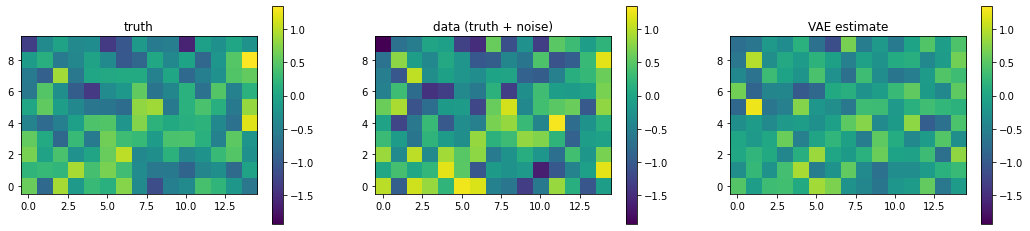

In [43]:
# Posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

posterior_predictions = Predictive(vae_predictive_model, mcmc_samples)(rng_pred)
post_obs = posterior_predictions['car_vae']

mean_post_pred_vae = np.mean(post_obs, axis=0)
bci_vae_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_vae_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_vae],
    titles=['truth', 'data (truth + noise)', 'VAE estimate'],
    figsize=(18, 4),
    image_shape=IMAGE_SHAPE,
);

mse_vae = 0.3032827377319336


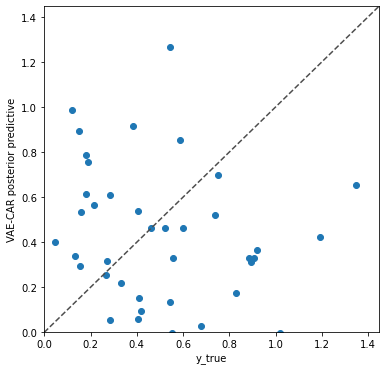

In [44]:
plotting.plot_compare_estimates(
    data_x=y_truth, data_y=mean_post_pred_vae,
    x_label='y_true', y_label='VAE-CAR posterior predictive',
    figsize=(6, 6),
)

mse_vae = np.mean((y_truth -  mean_post_pred_vae)**2)
print(f'mse_vae = {mse_vae}')

### Inference on observed data with CAR

In [45]:
import dill
mcmc_path = Path.cwd() / 'models/synthetic_car_mcmc_sampler.pkl'

OVERRIDE_LOAD = False

RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)
start = time.time()
if mcmc_path.exists():
    # Load sampler.
    with open(mcmc_path, 'rb') as f:
        mcmc = dill.load(f)
else:
    # Inference - smooth data and infer alpha
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(car_predictive_model_with_noise, 
                init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=2000
    )
    mcmc.run(rng_mcmc, CAR_ARGS, y=y_data)
    
    # Save sampler.
    with open(mcmc_path, 'wb') as f:
        dill.dump(mcmc, f)
        
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      0.72      0.13      0.73      0.49      0.92   1528.26      1.00
          car[0]      0.70      0.37      0.71      0.10      1.34   4645.38      1.00
          car[1]     -0.48      0.35     -0.48     -1.11      0.05   3080.83      1.00
          car[2]      0.75      0.35      0.76      0.17      1.33   3619.41      1.00
          car[3]      0.66      0.36      0.66      0.08      1.24   3711.01      1.00
          car[4]      0.34      0.35      0.34     -0.17      0.98   3549.83      1.00
          car[5]      0.96      0.35      0.97      0.37      1.50   3139.51      1.00
          car[6]      0.77      0.35      0.79      0.19      1.32   3339.61      1.00
          car[7]     -0.31      0.35     -0.32     -0.88      0.26   3951.70      1.00
          car[8]     -0.54      0.36     -0.54     -1.11      0.06   3167.06      1.00
          car[9]     -0.98      0.34     -

In [46]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 0 s
Average ESS for all CAR effects : 3398


In [47]:
# posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)
posterior_predictions = Predictive(
    car_predictive_model_with_noise, mcmc_samples)(rng_pred, CAR_ARGS, y=None)

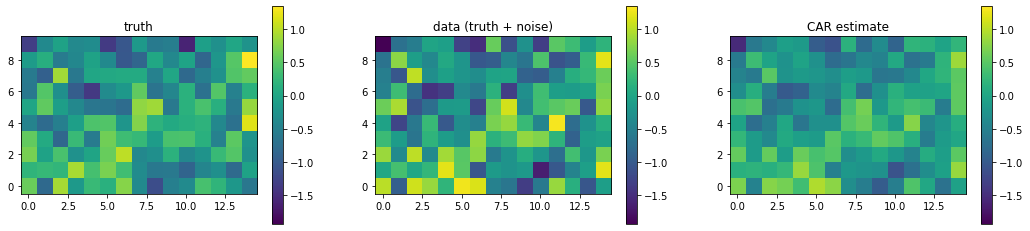

In [48]:
post_obs = posterior_predictions['car_samples']
mean_post_pred_car = np.mean(post_obs, axis=0)
bci_car_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_car_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_car = hpdi(post_obs, 0.9)

plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_car],
    titles=['truth', 'data (truth + noise)', 'CAR estimate'],
    figsize=(18, 4),
);

mse_car = 0.14492161571979523


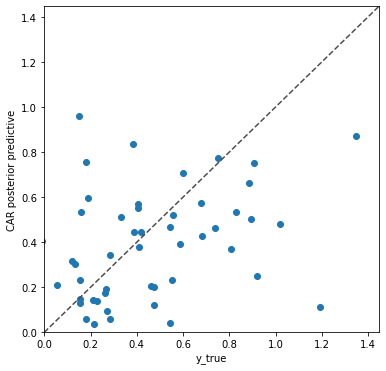

In [49]:
plotting.plot_compare_estimates(
    data_x=y_truth, data_y=mean_post_pred_car,
    x_label='y_true', y_label='CAR posterior predictive',
    figsize=(6, 6),
)

mse_car = np.mean((y_truth -  mean_post_pred_car)**2)
print(f'mse_car = {mse_car}')

mse_vgae_v_car = 0.17759636044502258


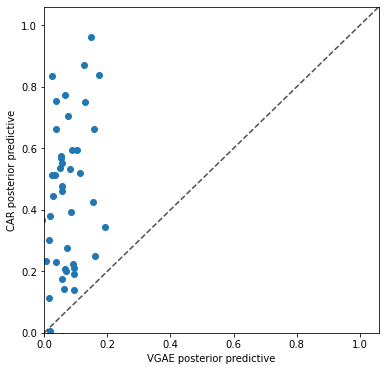

In [50]:
plotting.plot_compare_estimates(
    data_x=mean_post_pred_vgae, data_y=mean_post_pred_car,
    x_label='VGAE posterior predictive', y_label='CAR posterior predictive',
    figsize=(6, 6),
)

mse_vgae_v_car = np.mean((mean_post_pred_car -  mean_post_pred_vgae)**2)
print(f'mse_vgae_v_car = {mse_vgae_v_car}')

mse_vgae_v_vae = 0.1886155754327774


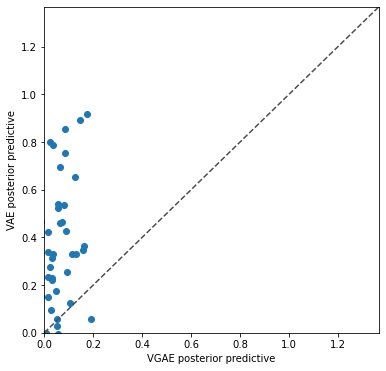

In [51]:
plotting.plot_compare_estimates(
    data_x=mean_post_pred_vgae, data_y=mean_post_pred_vae,
    x_label='VGAE posterior predictive', y_label='VAE posterior predictive',
    figsize=(6, 6),
)

mse_vgae_v_vae = np.mean((mean_post_pred_vae -  mean_post_pred_vgae)**2)
print(f'mse_vgae_v_vae = {mse_vgae_v_vae}')

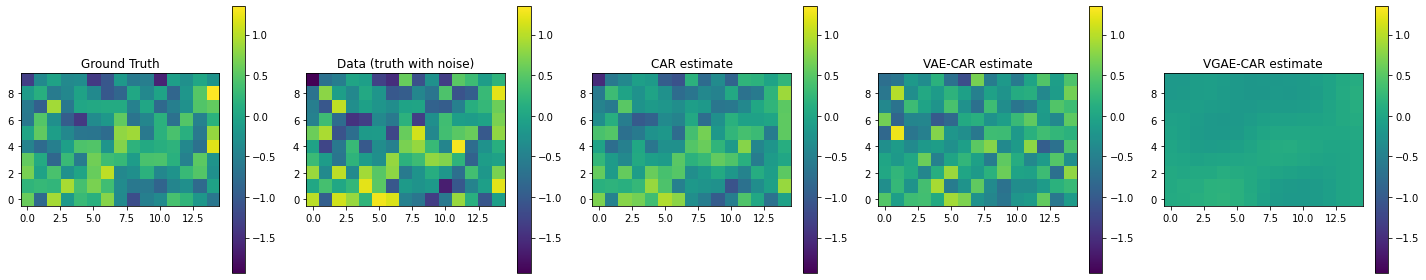

In [52]:
plotting.plot_images_from_arrays(
    arrays=[
        y_truth, 
        y_data, 
        mean_post_pred_car,
        mean_post_pred_vae,
        mean_post_pred_vgae,
    ],
    titles=[
        'Ground Truth',
        'Data (truth with noise)',
        'CAR estimate',
        'VAE-CAR estimate',
        'VGAE-CAR estimate',
    ],
    figsize=(20, 4)
)
plt.tight_layout()
plt.show()

In [53]:
print(f'MSE_CAR = {mse_car}')
print(f'MSE_VGAE = {mse_vgae}')
print(f'MSE_VAE = {mse_vae}')

MSE_CAR = 0.14492161571979523
MSE_VGAE = 0.2648072838783264
MSE_VAE = 0.3032827377319336


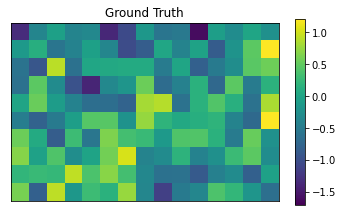

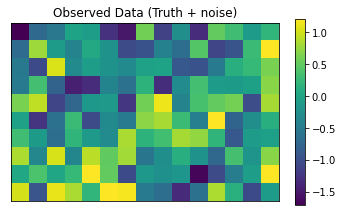

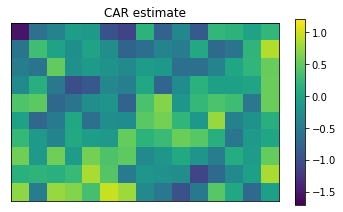

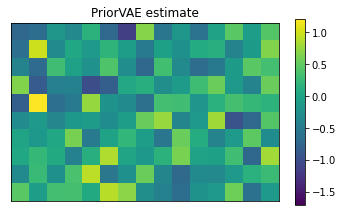

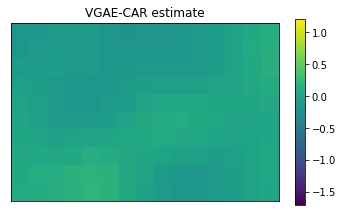

In [54]:
arrays = [y_truth, y_data, mean_post_pred_car, mean_post_pred_vae, mean_post_pred_vgae]
titles = ['Ground Truth', 'Observed Data (Truth + noise)', 'CAR estimate', 'PriorVAE estimate', 'VGAE-CAR estimate'] 
name_titles = [('_').join(title.lower().split()) for title in titles]
name_titles[1] = 'observed_data'

for arr, title, name_title in zip(arrays, titles, name_titles):
    fig, axes, _ = plotting.plot_images_from_arrays(
        arrays=[arr],
        titles=[title],
        figsize=(5, 3),
        custom_max = 1.2,
        custom_min = -1.7,
    )
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    fig_path = Path('./figures/CAR_figures')
    fig.savefig(fig_path / f'GAT_{name_title}.png', dpi=300)

In [55]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)


In [56]:
# _, ax = plt.subplots(figsize=(25, 8))

# idx = np.argsort(y_truth)

# xs = np.arange(0, num_x*num_y)
# ax.scatter(xs, y_truth[idx], label="truth", color='black', marker='x', s=50)
# ax.scatter(xs, mean_post_pred_car[idx], label="mean CAR", color='blue', s=20)
# ax.scatter(xs+0.15, mean_post_pred_vgae[idx], label="mean VGAE-CAR", color='red', s=20)
# ax.vlines(xs, bci_car_2_5[idx], bci_car_97_5[idx], linestyle="-",  linewidth=0.5, color='steelblue', label='95% BCI, CAR')
# ax.vlines(xs+0.15, bci_vgae_2_5[idx], bci_vgae_97_5[idx], linestyle="-", linewidth=0.5, color='red', label='95% BCI, VGAE-CAR')

# ax.set_xlabel('Area index')
# ax.set_ylabel('Estimated CAR')

# plt.legend()
# plt.show()

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3237: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


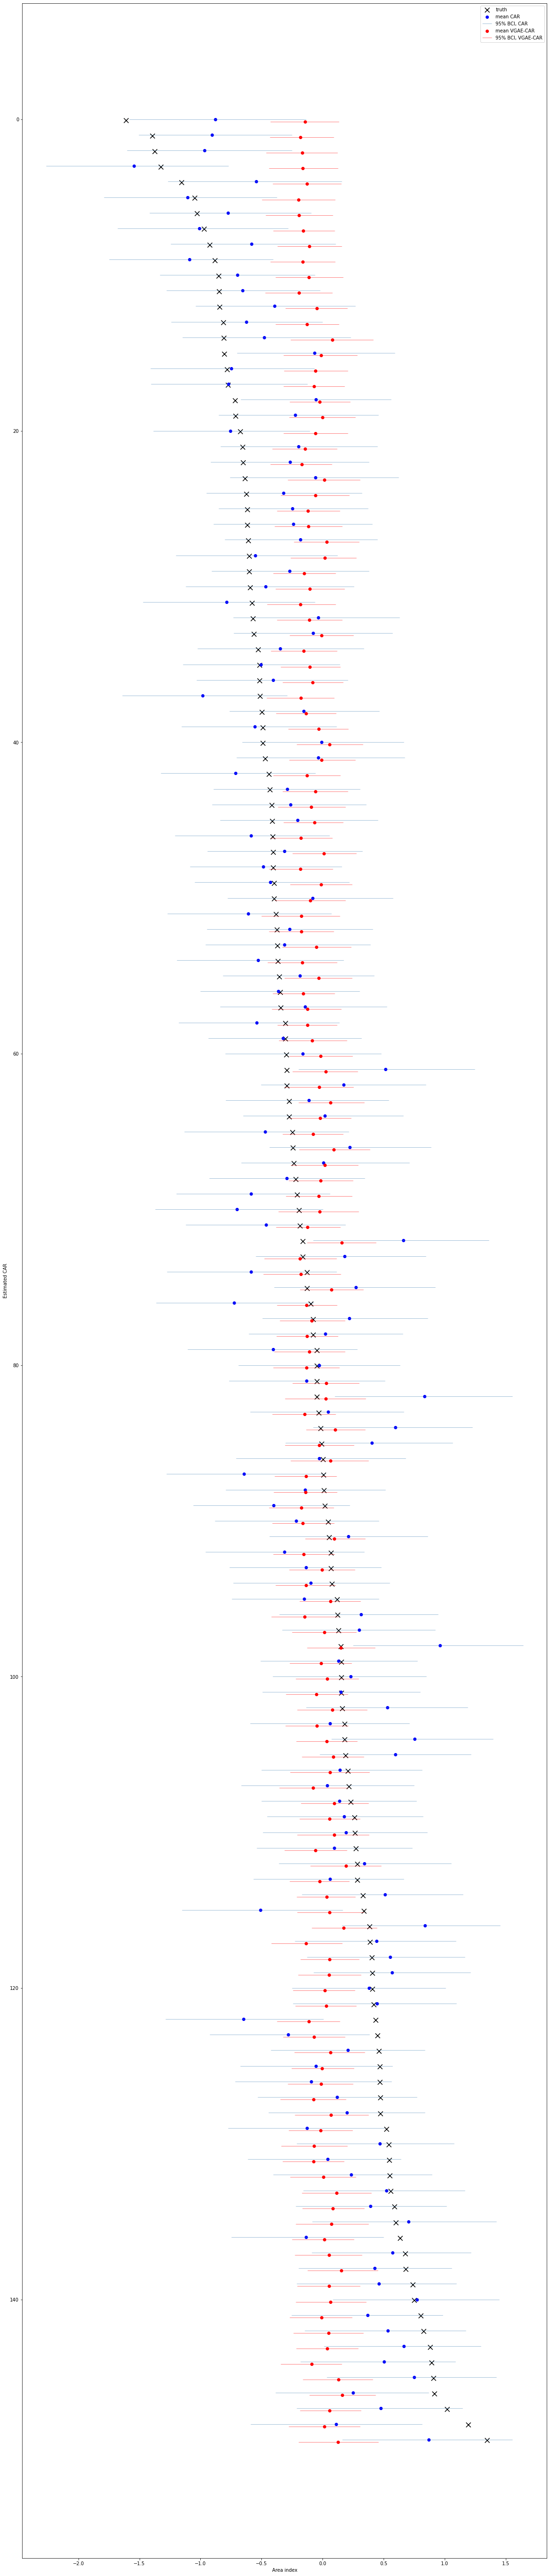

In [57]:
idx = np.argsort(y_truth)
xs = np.arange(0, num_x*num_y)

_, ax = plt.subplots(figsize=(20, 100))
ax.scatter(y_truth[idx], xs+0.05, label="truth", color='black', marker='x', s=100)

ax.scatter(mean_post_pred_car[idx], xs, label="mean CAR", color='blue')
ax.hlines(xs, bci_car_2_5[idx], bci_car_97_5[idx], linestyle="-",  linewidth=0.5, color='steelblue', label='95% BCI, CAR')

ax.scatter(mean_post_pred_vgae[idx], xs+0.15, label="mean VGAE-CAR", color='red')
ax.hlines(xs+0.15, bci_vgae_2_5[idx], bci_vgae_97_5[idx], linestyle="-", linewidth=0.5, color='red', label='95% BCI, VGAE-CAR')

ax.invert_yaxis()

ax.set_xlabel('Area index')
ax.set_ylabel('Estimated CAR')

plt.legend()
plt.show()

In [58]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x16a264ca0>, num_nodes=150, batch_size=1, scaler=None, linear_scale=None, hidden_dim=30, latent_dim=20, output_dim=1, learning_rate=0.0001, epochs=100000, beta=0.01, global_norm_clip=1.0, eval_frequency=1000)
